<a href="https://colab.research.google.com/github/briganln/Experiment-1/blob/main/Copy_of_Classification_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


from google.colab import drive

import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer


from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

In [2]:
class CustomDataset(Dataset):
    def __init__(self, imgs_path):
        self.imgs_path = imgs_path
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.png"): #changed to file extension png
                self.data.append([img_path, class_name])
        print(self.data)
        self.class_map = {"hp" : 0, "ssa": 1} #define two class names
        self.img_dim = (224, 224) # put this back to 224x224

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        img = img.astype(np.float32)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id


In [3]:
from google.colab import drive # mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
  batch_size = 32

  num_workers = 2

  transform = transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean = 0.5, std = 0.5

  # may need to add normalization from demo here (tensor)

  trainset = CustomDataset(imgs_path="/content/drive/MyDrive/Classification/images_train_sorted/**") #add ** for subfolders
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

  testset = CustomDataset(imgs_path="/content/drive/MyDrive/Classification/images_test_sorted/**")
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

    # specify the classes
  classes = ('hp', 'ssa')


['/content/drive/MyDrive/Classification/images_train_sorted/hp', '/content/drive/MyDrive/Classification/images_train_sorted/ssa']
[['/content/drive/MyDrive/Classification/images_train_sorted/hp/MHIST_blj.png', 'hp'], ['/content/drive/MyDrive/Classification/images_train_sorted/hp/MHIST_epo.png', 'hp'], ['/content/drive/MyDrive/Classification/images_train_sorted/hp/MHIST_bap.png', 'hp'], ['/content/drive/MyDrive/Classification/images_train_sorted/hp/MHIST_aux.png', 'hp'], ['/content/drive/MyDrive/Classification/images_train_sorted/hp/MHIST_aol.png', 'hp'], ['/content/drive/MyDrive/Classification/images_train_sorted/hp/MHIST_aut.png', 'hp'], ['/content/drive/MyDrive/Classification/images_train_sorted/hp/MHIST_aug.png', 'hp'], ['/content/drive/MyDrive/Classification/images_train_sorted/hp/MHIST_akp.png', 'hp'], ['/content/drive/MyDrive/Classification/images_train_sorted/hp/MHIST_aju.png', 'hp'], ['/content/drive/MyDrive/Classification/images_train_sorted/hp/MHIST_cdk.png', 'hp'], ['/conten

In [5]:
def imshow(img):
  ''' function to show image '''
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([32, 3, 224, 224])


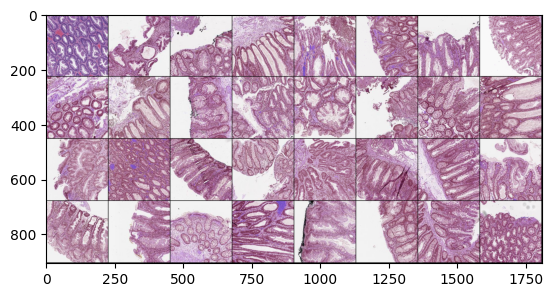

hp ssa ssa hp hp hp hp hp hp ssa ssa hp hp hp hp hp hp hp hp hp hp ssa hp ssa hp ssa hp hp ssa hp hp hp


In [7]:

images *= (1.0/images.max())

combined_images=torchvision.utils.make_grid(images)
imshow(combined_images)
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [8]:
import time
import numpy as np
import os
import pydot
from typing import List, Tuple
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image
import pathlib
import shutil

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model

from tensorflow.python.keras.utils import layer_utils
#from tensorflow.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.imagenet_utils import preprocess_input

from IPython.display import SVG

import scipy.misc

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last') # can be channels_first or channels_last.
K.set_learning_phase(1) # 1 stands for learning phase

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [9]:
def identity_block(X: tf.Tensor, level: int, block: int, filters: List[int]) -> tf.Tensor:
    """
    Creates an identity block (see figure 3.1 from readme)

    Input:
        X - input tensor of shape (m, height_prev, width_prev, chan_prev)
        level - integer, one of the 5 levels that our networks is conceptually divided into (see figure 3.1 in the readme file)
              - level names have the form: conv2_x, conv3_x ... conv5_x
        block - each conceptual level has multiple blocks (1 identity and several convolutional blocks)
                block is the number of this block within its conceptual layer
                i.e. first block from level 2 will be named conv2_1
        filters - a list on integers, each of them defining the number of filters in each convolutional layer

    Output:
        X - tensor (m, height, width, chan)
    """

    # layers will be called conv{level}_iden{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the identity block
    # takes the value of the block input
    X_shortcut = X

    # first convolutional layer (plus batch norm & relu activation, of course)
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1),
               padding='same', name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu')(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # relu activation at the end of the block
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

In [10]:
def convolutional_block(X: tf.Tensor, level: int, block: int, filters: List[int], s: Tuple[int,int,int]=(2, 2)) -> tf.Tensor:
    """
    Creates a convolutional block (see figure 3.1 from readme)

    Input:
        X - input tensor of shape (m, height_prev, width_prev, chan_prev)
        level - integer, one of the 5 levels that our networks is conceptually divided into (see figure 3.1 in the readme file)
              - level names have the form: conv2_x, conv3_x ... conv5_x
        block - each conceptual level has multiple blocks (1 identity and several convolutional blocks)
                block is the number of this block within its conceptual layer
                i.e. first block from level 2 will be named conv2_1
        filters - a list on integers, each of them defining the number of filters in each convolutional layer
        s   - stride of the first layer;
            - a conv layer with a filter that has a stride of 2 will reduce the width and height of its input by half

    Output:
        X - tensor (m, height, width, chan)
    """

    # layers will be called conv{level}_{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the convolutional block
    X_shortcut = X

    # first convolutional layer
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=s, padding='valid',
               name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same',
               name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=2, type='relu'))(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # shortcut path
    X_shortcut = Conv2D(filters=f3, kernel_size=(1, 1), strides=s, padding='valid',
                        name=conv_name.format(layer='short', type='conv'),
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=conv_name.format(layer='short', type='bn'))(X_shortcut)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # nonlinearity
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X


In [11]:
def ResNet50(input_size: Tuple[int,int,int], classes: int) -> Model:
    """
        Builds the ResNet50 model (see figure 4.2 from readme)

        Input:
            - input_size - a (height, width, chan) tuple, the shape of the input images
            - classes - number of classes the model must learn

        Output:
            model - a Keras Model() instance
    """

    # tensor placeholder for the model's input
    X_input = Input(input_size)

    ### Level 1 ###

    # padding
    X = ZeroPadding2D((3, 3))(X_input)

    # convolutional layer, followed by batch normalization and relu activation
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2),
               name='conv1_1_1_conv',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='conv1_1_1_nb')(X)
    X = Activation('relu')(X)

    ### Level 2 ###

    # max pooling layer to halve the size coming from the previous layer
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 1x convolutional block
    X = convolutional_block(X, level=2, block=1, filters=[64, 64, 256], s=(1, 1))

    # 2x identity blocks
    X = identity_block(X, level=2, block=2, filters=[64, 64, 256])
    X = identity_block(X, level=2, block=3, filters=[64, 64, 256])

    ### Level 3 ###

    # 1x convolutional block
    X = convolutional_block(X, level=3, block=1, filters=[128, 128, 512], s=(2, 2))

    # 3x identity blocks
    X = identity_block(X, level=3, block=2, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=3, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=4, filters=[128, 128, 512])

    ### Level 4 ###
    # 1x convolutional block
    X = convolutional_block(X, level=4, block=1, filters=[256, 256, 1024], s=(2, 2))
    # 5x identity blocks
    X = identity_block(X, level=4, block=2, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=3, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=4, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=5, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=6, filters=[256, 256, 1024])

    ### Level 5 ###
    # 1x convolutional block
    X = convolutional_block(X, level=5, block=1, filters=[512, 512, 2048], s=(2, 2))
    # 2x identity blocks
    X = identity_block(X, level=5, block=2, filters=[512, 512, 2048])
    X = identity_block(X, level=5, block=3, filters=[512, 512, 2048])

    # Pooling layers
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc_' + str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [12]:
# set input image parameters
image_size = (224, 224)
channels = 3
num_classes = 2

In [13]:
model = ResNet50(input_size = (image_size[1], image_size[0], channels), classes = num_classes)

In [14]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1_1_1_conv (Conv2D)     (None, 112, 112, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1_1_1_nb (BatchNormali  (None, 112, 112, 64)         256       ['conv1_1_1_conv[0][0]'

In [15]:
# path to desired image set, relative to current working dir
in_folder = os.path.join('/content/drive/MyDrive/Classification/images_train_sorted')

file_count = []

# get number of images in each folder (images per class)
for fld in os.listdir(in_folder):
    crt = os.path.join(in_folder, fld)

    image_count = len(os.listdir(crt))

    file_count.append(image_count)

    print(f'{crt} contains {image_count} images')

/content/drive/MyDrive/Classification/images_train_sorted/hp contains 1539 images
/content/drive/MyDrive/Classification/images_train_sorted/ssa contains 674 images


In [16]:
print(f'Total number of images: {sum(file_count)}')

Total number of images: 2213


In [17]:
os.listdir(os.path.join(in_folder, 'hp'))[:10]

['MHIST_blj.png',
 'MHIST_epo.png',
 'MHIST_bap.png',
 'MHIST_aux.png',
 'MHIST_aol.png',
 'MHIST_aut.png',
 'MHIST_aug.png',
 'MHIST_akp.png',
 'MHIST_aju.png',
 'MHIST_cdk.png']

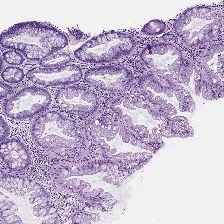

In [18]:
data_dir = pathlib.Path(in_folder)

hp = list(data_dir.glob('hp/*'))

PIL.Image.open(str(hp[0]))

In [19]:
PIL.Image.open(str(hp[0])).size

(224, 224)

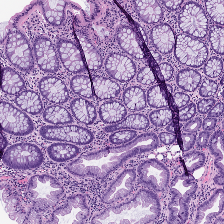

In [20]:
PIL.Image.open(str(hp[10]))

In [21]:
PIL.Image.open(str(hp[10])).size

(224, 224)

In [22]:
# path to output folder, relative to current working dir
out_folder = os.path.join('/content/drive/MyDrive/Classification/images_train_output')

In [23]:
def square_crop_image(im: PIL.Image) -> PIL.Image:
    width, height = im.size
    new_size = min(width, height)

    # center crop
    left = (width - new_size) / 2
    top = (height - new_size) / 2
    right = (width + new_size) / 2
    bottom = (height + new_size) / 2

    crop_im = im.crop((left, top, right, bottom))
    crop_im = crop_im.convert('RGB')

    return crop_im

In [24]:
def make_dataset(in_folder, im_per_class):
    # iterate through all folders (there should be one folder per object class)
    for fld in os.listdir(in_folder):
        # create the output folder for processed images for current class
        # delete folder and contents if there is one already
        out = os.path.join(out_folder, fld)
        if os.path.exists(out):
            shutil.rmtree(out)
        os.makedirs(out)

        fld_path = pathlib.Path(os.path.join(in_folder, fld))
        num_images = 0
        for file in list(fld_path.glob('*')):
            # open image, center crop to a square
            # save to the output folder
            with PIL.Image.open(file) as im:
                crop_im = square_crop_image(im)
                crop_im.save(os.path.join(out, str(num_images) + '.jpg'))
                #im.close()
            # break when desired number of images
            # has been processed (to keep classes balance)
            num_images = num_images + 1
            if (num_images > im_per_class):
                break

In [25]:
#open(in_folder, 'r+')

# get the number of images that will make our classes balanced
im_per_class = min(file_count)

# process input images
make_dataset(in_folder, im_per_class)

In [26]:
img_height = image_size[1]
img_width = image_size[0]
batch_size = 32

In [27]:
data_dir = pathlib.Path(out_folder)

In [28]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    label_mode='categorical', # default mode is 'int' label, but we want one-hot encoded labels (e.g. for categorical_crossentropy loss)
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1349 files belonging to 2 classes.
Using 1080 files for training.
Found 1349 files belonging to 2 classes.
Using 269 files for validation.


In [29]:
class_names = train_ds.class_names
print(class_names)

['hp', 'ssa']


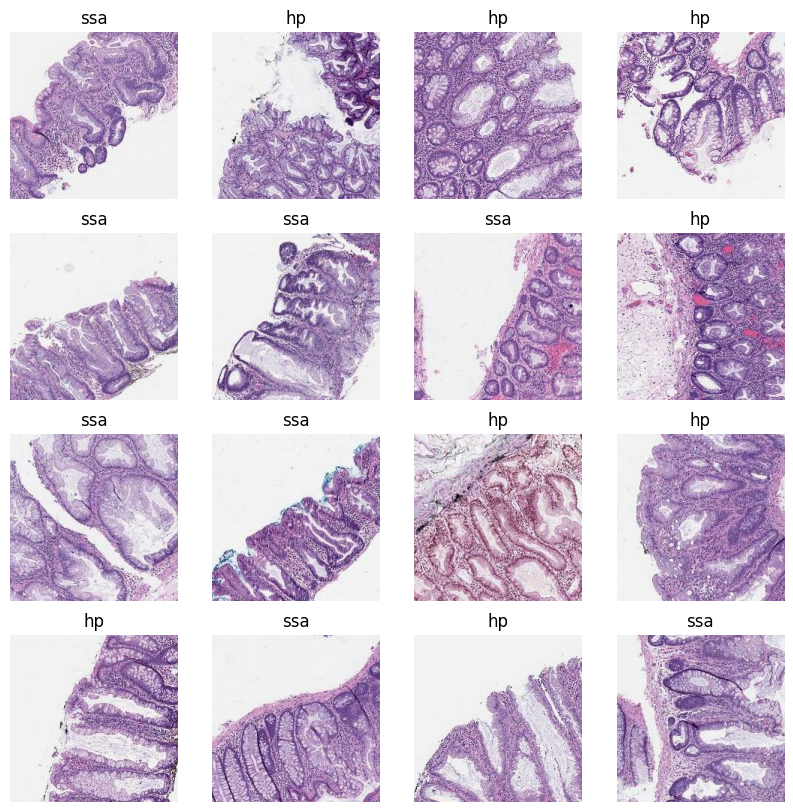

In [30]:
plt.figure(figsize=(10, 10))

i = 1

for images, labels in train_ds.take(1):
    for (image, label) in zip(images, labels):
        ax = plt.subplot(4, 4, i)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(label, axis=0)])
        plt.axis("off")
        i = i + 1
        if i == 17:
            break
plt.show()

In [31]:
# use keras functionality for adding a rescaling layer
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

# rescale training and validation sets
norm_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
norm_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [32]:
image_batch, labels_batch = next(iter(norm_train_ds))

# get one image
first_image = image_batch[0]

# confirm pixel values are now in the [0,1] range
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [33]:
model.compile(
    optimizer='adam', # optimizer
    loss='categorical_crossentropy', # loss function to optimize
    metrics=['accuracy'] # metrics to monitor
)

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

norm_train_ds = norm_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
norm_val_ds = norm_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
import time

start = time.time()

model.fit(
    norm_train_ds,
    validation_data=norm_val_ds,
    epochs = 2)

stop = time.time()

print(f'Training took: {(stop-start)/60} minutes')

Epoch 1/2


KeyboardInterrupt: ignored

In [36]:
model_on_gpu = ResNet50(input_size = (image_size[1], image_size[0], channels), classes = num_classes)
model_on_gpu.compile(
    optimizer='adam', # optimizer
    loss='categorical_crossentropy', # loss function to optimize
    metrics=['accuracy'] # metrics to monitor
)

In [37]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


In [38]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", # monitor validation loss (that is, the loss computed for the validation holdout)
        min_delta=1e-2, # "no longer improving" being defined as "an improvement lower than 1e-2"
        patience=10, # "no longer improving" being further defined as "for at least 10 consecutive epochs"
        verbose=1
    )
]

In [40]:
start = time.time()
with tf.device('/gpu:0'):
    history = model_on_gpu.fit(
        norm_train_ds,
        validation_data=norm_val_ds,
        epochs=20,
        callbacks=callbacks,
    )
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')

Epoch 1/20
34/34 [==============================] - 576s 17s/step - loss: 1.1912 - accuracy: 0.5833 - val_loss: 2.0047 - val_accuracy: 0.4535
Epoch 2/20
34/34 [==============================] - 570s 17s/step - loss: 1.2477 - accuracy: 0.6407 - val_loss: 0.8211 - val_accuracy: 0.4572
Epoch 3/20
34/34 [==============================] - 568s 17s/step - loss: 0.8047 - accuracy: 0.7065 - val_loss: 0.7470 - val_accuracy: 0.4758
Epoch 4/20
34/34 [==============================] - 572s 17s/step - loss: 0.6927 - accuracy: 0.8241 - val_loss: 0.7147 - val_accuracy: 0.5428
Epoch 5/20
34/34 [==============================] - 562s 17s/step - loss: 0.4798 - accuracy: 0.8685 - val_loss: 1.0709 - val_accuracy: 0.4572
Epoch 6/20
34/34 [==============================] - 559s 16s/step - loss: 0.7481 - accuracy: 0.7981 - val_loss: 4.7766 - val_accuracy: 0.5279
Epoch 7/20
34/34 [==============================] - 565s 17s/step - loss: 1.0418 - accuracy: 0.6093 - val_loss: 72.5170 - val_accuracy: 0.5465
Epoch

In [ ]:
while True:pass

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


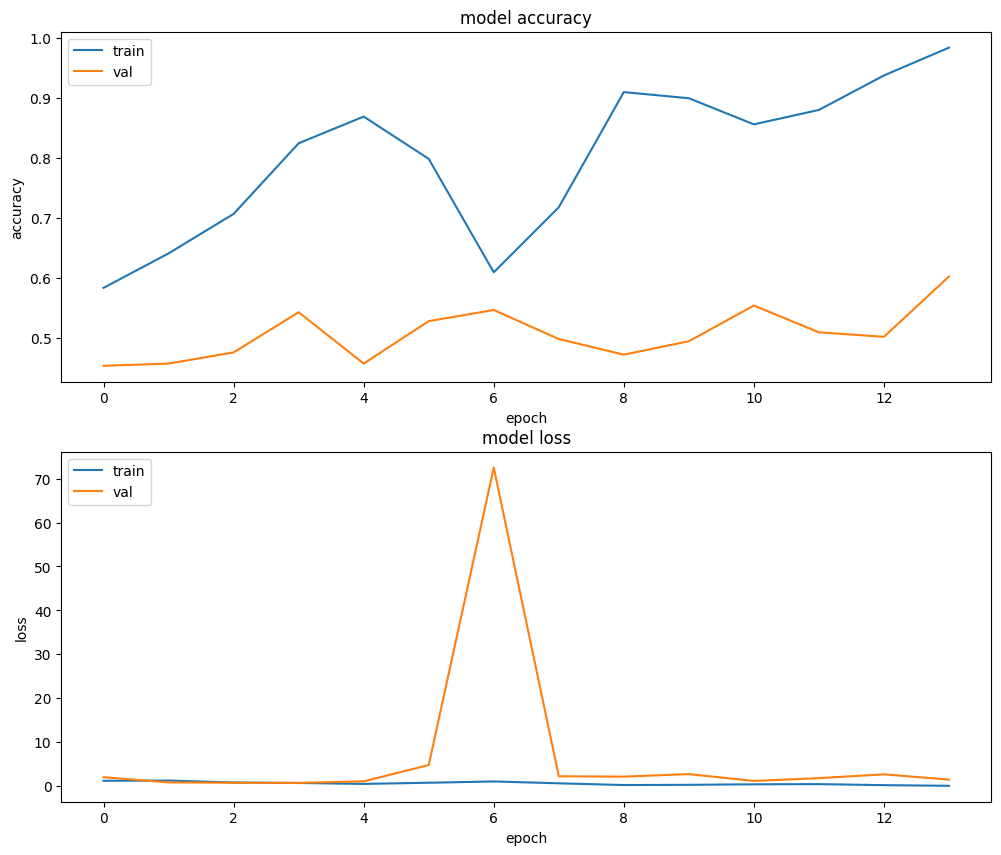

In [41]:
print(history.history.keys())

plt.figure(figsize=(12, 10))

# summarize history for accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
#preds = model_on_gpu.evaluate(X_test, Y_test)
preds = model_on_gpu.evaluate(norm_val_ds)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

9/9 [==============================] - 32s 4s/step - loss: 1.4618 - accuracy: 0.6022
Loss = 1.461811900138855
Test Accuracy = 0.6022304892539978


Input image shape: (224, 224, 3)


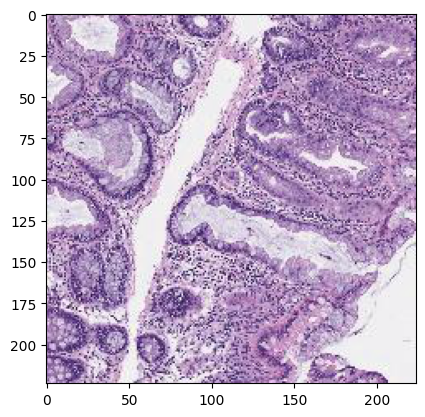

In [160]:
import cv2

test_img_path = '/content/drive/MyDrive/Classification/images_eval/MHIST_ejf.png'

# read image
img = cv2.imread(test_img_path)

# reorder RGB channels (opencv reads as BGR by default)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# resize to the same input image size that we used when defining the model architecture
x = cv2.resize(RGB_img, image_size, interpolation = cv2.INTER_AREA)

print('Input image shape:', x.shape) # sanity check

plt.imshow(RGB_img)

In [161]:
x = np.expand_dims(x, axis=0) # fake batch size dimension
x = x/255.0 # normalize pixel values to [0,1] interval

preds = model_on_gpu.predict(x) # get model predictions

print("Model's prediction has this format: [p(0), p(1), ... , p(5)] = ")
print(preds)



print("The prediction for this image is: ", class_names[np.argmax(preds)])

1/1 [==============================] - 0s 183ms/step
Model's prediction has this format: [p(0), p(1), ... , p(5)] = 
[[0.994279   0.00572093]]
The prediction for this image is:  hp


In [45]:
len(preds[0])

for i, p in enumerate(preds[0]):
    print(f'p:{p:.05f}\t{class_names[i]}')

p:0.99942	hp
p:0.00058	ssa


In [48]:
model_on_gpu_40e = ResNet50(input_size = (image_size[1], image_size[0], channels), classes = len(class_names))

model_on_gpu_40e.compile(
    optimizer='adam', # optimizer
    loss='categorical_crossentropy', # loss function to optimize
    metrics=['accuracy'] # metrics to monitor
)

start = time.time()
with tf.device('/gpu:0'):
    history = model_on_gpu_40e.fit(
        norm_train_ds,
        validation_data=norm_val_ds,
        epochs=10,
        #batch_size=64,
    )
stop = time.time()

print(f'Training for 40 epochs on GPU took: {(stop-start)/60} minutes')

Epoch 1/10
18/34 [==============>...............] - ETA: 4:10 - loss: 4.7099 - accuracy: 0.5208

KeyboardInterrupt: ignored

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


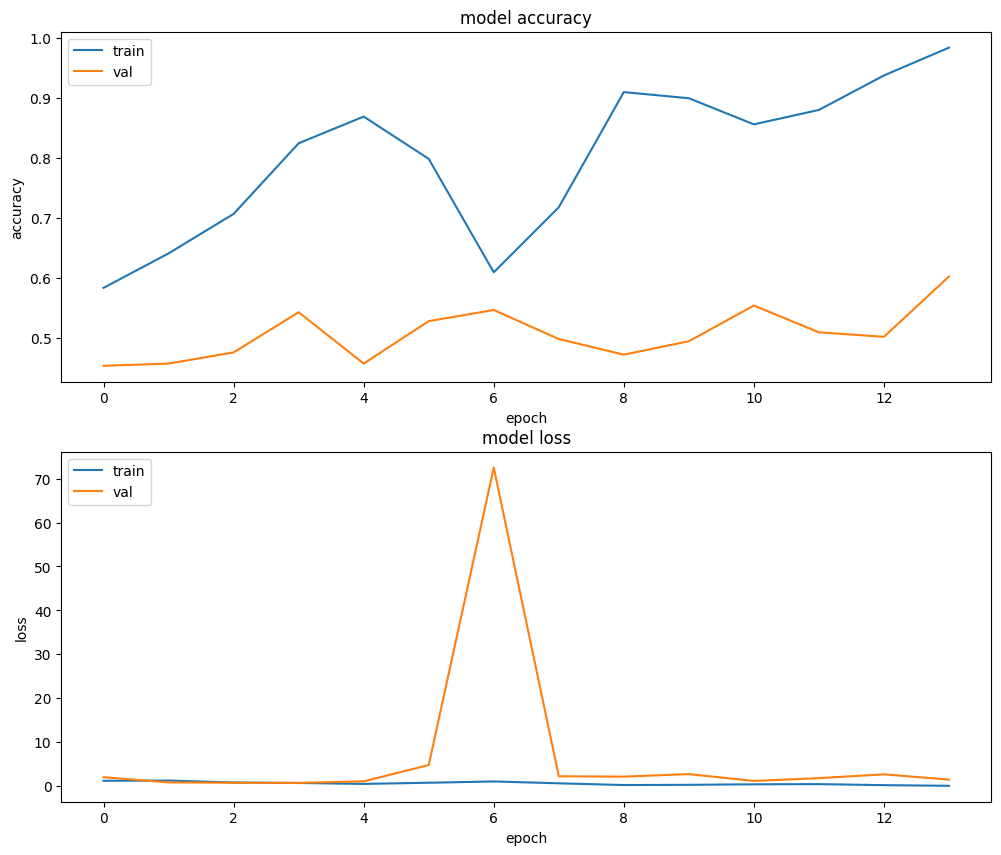

In [47]:
print(history.history.keys())

plt.figure(figsize=(12, 10))

# summarize history for accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

AttributeError: ignored

In [ ]:
criterion = nn.CrossEntropyLoss() #need a loss - need good classification to follow (look for examples onlien)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#training with for loop
net = Net()

for epoch in range(500):  # loop over the dataset multiple times (loops through dataset 2 times) # prob need more than 2 (couple hundred)
    print(f'Epoch number = {epoch}')
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]

        inputs, labels = data #inputs (images)
        labels=labels.squeeze()

        # zero the parameter gradients (initializing optimizer)
        optimizer.zero_grad()

        # forward + backward + optimize ()
        outputs = net(inputs) #good func - all inputs applies NN and gets outputs all in one line, output = labels, propogate data
        loss = criterion(outputs, labels) #loss funciton (corss entropy loss, find right criterion online), whats err in network
        loss.backward() #propogate back through netswork to update wqeight and try to minimize loss, reading back through data
        optimizer.step() #let it know its progressed one more iteration

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches (might need to change 200 size here*****)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000)) #pretty prints how well algorithm is doing as its progressing, loss at each internal printed out
            running_loss = 0.0 # lower numbers are better, how well do they correlate loss and image

Epoch number = 0
Epoch number = 1
Epoch number = 2
Epoch number = 3
Epoch number = 4
Epoch number = 5
Epoch number = 6
Epoch number = 7
Epoch number = 8
Epoch number = 9
Epoch number = 10
Epoch number = 11
Epoch number = 12
Epoch number = 13
Epoch number = 14
Epoch number = 15
Epoch number = 16
Epoch number = 17
Epoch number = 18
Epoch number = 19
Epoch number = 20
Epoch number = 21
Epoch number = 22
Epoch number = 23
Epoch number = 24
Epoch number = 25
Epoch number = 26
Epoch number = 27
Epoch number = 28
Epoch number = 29
Epoch number = 30
Epoch number = 31
Epoch number = 32
Epoch number = 33
Epoch number = 34
Epoch number = 35
Epoch number = 36
Epoch number = 37
Epoch number = 38


In [ ]:

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        labels = labels.squeeze()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted.shape)
        total += labels.size(0)
        print(f'total = {total}')
        correct += (predicted == labels).sum().item()
        print(f'correct = {correct}')

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

torch.Size([32])
total = 32
correct = 15
torch.Size([32])
total = 64
correct = 32
torch.Size([32])
total = 96
correct = 42
torch.Size([32])
total = 128
correct = 58
torch.Size([32])
total = 160
correct = 72
torch.Size([32])
total = 192
correct = 88
torch.Size([32])
total = 224
correct = 112
torch.Size([32])
total = 256
correct = 129
torch.Size([32])
total = 288
correct = 144
torch.Size([32])
total = 320
correct = 163
torch.Size([32])
total = 352
correct = 177
torch.Size([32])
total = 384
correct = 192
torch.Size([32])
total = 416
correct = 213
torch.Size([32])
total = 448
correct = 229
torch.Size([32])
total = 480
correct = 245
torch.Size([32])
total = 512
correct = 260
torch.Size([32])
total = 544
correct = 269
torch.Size([32])
total = 576
correct = 288
Accuracy of the network on test images: 50 %
